# Supervised Learning Using Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from imblearn.keras import BalancedBatchGenerator


Using TensorFlow backend.


## Part 2: Supervised Learning Model

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_train.shape

(42962, 367)

In [4]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

In [5]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [6]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

### Get to know the data

In [7]:
X_clean = X

# Drop columns not in data dictionary
#missing_from_feat_info = set(X_clean.columns.values).difference(feat_info.index.values)
#X_clean.drop(list(missing_from_feat_info), axis='columns', inplace=True)

# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
X_clean[X_clean.isin(missing_values)] = np.nan

In [8]:
X_clean.shape

(42962, 366)

In [9]:
# Missing values by column
p_missing = (X_clean.isnull().sum() / X_clean.shape[0])
p_missing.sort_values(ascending=False).head(20)

ALTER_KIND4       0.999046
ALTER_KIND3       0.995950
TITEL_KZ          0.995042
ALTER_KIND2       0.982403
ALTER_KIND1       0.953727
KK_KUNDENTYP      0.589265
KBA05_BAUMAX      0.534891
AGER_TYP          0.439691
GEBURTSJAHR       0.406755
EXTSEL992         0.371212
ALTER_HH          0.306713
W_KEIT_KIND_HH    0.242470
KKK               0.231134
REGIOTYP          0.231134
HH_DELTA_FLAG     0.225269
KBA05_MOD3        0.210209
KBA05_MOD2        0.210209
KBA05_MOD1        0.210209
KBA05_MAXSEG      0.210209
KBA05_MAXVORB     0.210209
dtype: float64

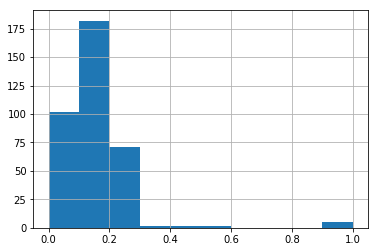

In [10]:
p_missing.hist();

In [11]:
col_threshold = .22
to_drop = p_missing[p_missing >= col_threshold]
to_drop.index

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'HH_DELTA_FLAG',
       'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ',
       'W_KEIT_KIND_HH'],
      dtype='object')

In [12]:
X_clean = X_clean.drop(to_drop.index, axis=1)
X_clean.shape

(42962, 351)

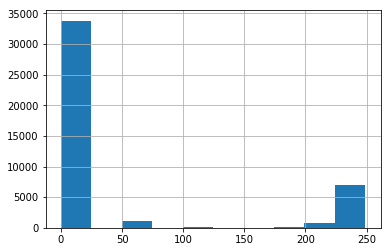

In [13]:
# Missing values by row
n_missing = X_clean.isnull().sum(axis=1)
n_missing.hist();

In [14]:
X_clean['RESPONSE'] = y

In [15]:
above_yes = X_clean[(n_missing > 150) & (X_clean.RESPONSE == 1)]
above_yes.shape

(96, 352)

Keep all rows because we would lose too many positive responses.

### Clean Data 

In [7]:
def clean_data(df, feat_info, row_threshold):
    clean_df = df.copy()
    
    # Drop unwanted columns    
#    missing_from_feat_info = set(clean_df.columns.values).difference(feat_info.index.values)
#    clean_df.drop(list(missing_from_feat_info), axis='columns', inplace=True)
    
    # Convert missing values to Nans
    missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
    clean_df[clean_df.isin(missing_values)] = np.nan
    
    # Drop columns with missing values
#    to_drop = ['AGER_TYP','ALTER_HH','GEBURTSJAHR','HH_DELTA_FLAG','KBA05_BAUMAX','KK_KUNDENTYP','KKK','REGIOTYP','TITEL_KZ','W_KEIT_KIND_HH']
    
    to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'HH_DELTA_FLAG',
       'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ',
       'W_KEIT_KIND_HH']
    
    clean_df = clean_df.drop(to_drop, axis='columns')

    # Don't drop KBA columns
    
    # Drop rows with missing values
    missing_by_row = clean_df.isnull().sum(axis=1)

    dropped_df = clean_df[missing_by_row > row_threshold]
    clean_df = clean_df[missing_by_row <= row_threshold]
    
    # Feature Re-encoding and Engineering
    # Recode 10's to 0 for D19 columns that need it
    recode = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM']
    clean_df[recode] = clean_df[recode].replace(10, 0)
    
    # Drop all fine scale variables in favor of the rough scale version
    drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
    clean_df.drop(drop, axis=1, inplace=True)
    
    # convert CAMEO_DEUG_2015 from string to float
    clean_df['CAMEO_DEUG_2015'] = clean_df['CAMEO_DEUG_2015'].astype(float)
    
    # Re-encode categorical variable(s) to be kept in the analysis
    recoded = pd.get_dummies(clean_df['OST_WEST_KZ'])
    clean_df.drop('OST_WEST_KZ', axis=1, inplace=True)
    clean_df = pd.concat([clean_df, recoded], axis=1)

    # Engineer new variables
    to_replace = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    clean_df['decade'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)

    to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    clean_df['movement'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)    

    clean_df['wealth'] = clean_df.CAMEO_INTL_2015[clean_df.CAMEO_INTL_2015.notnull()].map(lambda x: int(str(x)[0]))
    clean_df['life_stage'] = clean_df.CAMEO_INTL_2015[clean_df.CAMEO_INTL_2015.notnull()].map(lambda x: int(str(x)[1]))
    
    # Drop unneeded variables
    clean_df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015',
                   'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN',
                   'LNR', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)

    # Return the cleaned dataframe and dropped rows.
    return clean_df, dropped_df

In [8]:
X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train.columns))
print(X_clean.shape)
print(X_dropped.shape)

(42962, 346)
(0, 351)


### Preprocess

In [10]:
numeric = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
numeric

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'MIN_GEBAEUDEJAHR'],
      dtype='object', name='attribute')

In [9]:
numerical_columns = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

categorical_columns = X_clean.columns.drop(numerical_columns)
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'))

preprocessor = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_columns),
     ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
    remainder='drop')

In [11]:
X_clean.dtypes.value_counts()

float64    260
int64       84
uint8        2
dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, stratify=y, random_state=42)

X_train = preprocessor.fit_transform(X_train)
print(X_train.shape)

X_test = preprocessor.transform(X_test)

(34369, 346)


### Model

In [43]:
def make_model(n_features, learn_rate):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learn_rate),
                  metrics=['acc'])

    return model

In [44]:
# Balanced Batches
def fit_predict_balanced_model(X_train, y_train):
    model = make_model(X_train.shape[1], 0.001)
    training_generator = BalancedBatchGenerator(X_train, y_train, batch_size=64, random_state=42)
    model.fit_generator(generator=training_generator, epochs=90, verbose=False)
    return model

In [80]:
balanced = fit_predict_balanced_model(X_train, y_train)

In [82]:
y_pred = balanced.predict_proba(X_test)
#threshold = 0.5
#y_pred = np.where(y_pred > threshold, 1, 0)

#y_pred = model.predict_classes(X_test)
print(y_pred[0:5])
print(roc_auc_score(y_test, y_pred))

[[1.3334392e-23]
 [3.8051503e-18]
 [5.6731080e-22]
 [6.7245648e-19]
 [2.2927112e-11]]
0.646819441943394


In [104]:
# Standard model
def fit_predict_model(X_train, y_train, X_test, y_test, class_weight={0:1, 1:1}):
    model = make_model(X_train.shape[1], 0.001)
    
    start_time = time.time()

    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=False, class_weight=class_weight)
    
    elapsed_time = time.time() - start_time
    print('Elapsed computation time: {:.3f} secs'
          .format(elapsed_time))

    y_pred = model.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred))
    
    return model

In [92]:
base = fit_predict_model(X_train, y_train, X_test, y_test)

Elapsed computation time: 109.166 secs
0.5


In [95]:
y_pred = base.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

0.6260618348595299


In [30]:
# Used class weights
y_train.value_counts()[0]/y_train.value_counts()[1]

79.67840375586854

In [93]:
class_weight = {0:1, 1:50}
weighted = fit_predict_model(X_train, y_train, X_test, y_test, class_weight)

Elapsed computation time: 113.519 secs
0.5177602370773503


In [97]:
y_pred = weighted.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

0.6093970578754188


In [84]:
# Dealing with the class imbalance
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_sample(X_train, y_train)

In [88]:
pd.value_counts(y_cc)

1    426
0    426
dtype: int64

In [99]:
cc_model = fit_predict_model(X_cc, y_cc, X_test, y_test)
y_pred = weighted.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

Elapsed computation time: 5.946 secs
0.5
0.6093970578754188


In [100]:
# use SMOTE
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

In [101]:
pd.value_counts(y_smote)

1    33943
0    33943
dtype: int64

In [102]:
smote = fit_predict_model(X_smote, y_smote, X_test, y_test)

Elapsed computation time: 197.753 secs
0.5


In [103]:
y_pred = model.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.575618426405757


### Hyperparameter Optimization

In [31]:
# Use all of the training data since we're using cross-validation
X_processed = preprocessor.fit_transform(X_clean)
print(X_processed.shape)

(42962, 346)


#### Select optimizer

In [32]:
model = KerasClassifier(build_fn=make_model, epochs=30, batch_size=64, verbose=False)
param_grid = {'n_features':[X_processed.shape[1]],
              'optimizer':['SGD', 'Adam']}

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_processed, y)

elapsed_time = time.time() - start_time
print('Elapsed computation time: {:.3f} secs'
      .format(elapsed_time))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Elapsed computation time: 489.908 secs
Best: 0.592133 using {'n_features': 346, 'optimizer': 'Adam'}


#### Tune learning rate

In [34]:
def make_model(n_features, learn_rate=0.001):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

    return model

In [40]:
model = KerasClassifier(build_fn=make_model, epochs=30, batch_size=64, verbose=False)
param_grid = {'n_features':[X_processed.shape[1]],
              'learn_rate':[0.0001],
              'epochs':[20, 30, 40]}
#              'batch_size':[32, 64]}

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_processed, y)

elapsed_time = time.time() - start_time
print('Elapsed computation time: {:.3f} secs'
      .format(elapsed_time))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Elapsed computation time: 1051.038 secs
Best: 0.638670 using {'epochs': 40, 'learn_rate': 0.0001, 'n_features': 346}


In [41]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.625591 (0.018980) with: {'epochs': 20, 'learn_rate': 0.0001, 'n_features': 346}
0.629509 (0.020828) with: {'epochs': 30, 'learn_rate': 0.0001, 'n_features': 346}
0.638670 (0.018953) with: {'epochs': 40, 'learn_rate': 0.0001, 'n_features': 346}


0.653540 (0.015685) with: {'epochs': 30, 'learn_rate': 0.0001, 'n_features': 346}
0.643843 (0.005525) with: {'epochs': 40, 'learn_rate': 0.0001, 'n_features': 346}

In [42]:
param_grid = {'n_features':[X_processed.shape[1]],
              'learn_rate':[0.0001],
              'batch_size':[32, 64]}

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_processed, y)

elapsed_time = time.time() - start_time
print('Elapsed computation time: {:.3f} secs'
      .format(elapsed_time))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Elapsed computation time: 990.465 secs
Best: 0.664592 using {'batch_size': 64, 'learn_rate': 0.0001, 'n_features': 346}


In [43]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.655577 (0.009200) with: {'batch_size': 32, 'learn_rate': 0.0001, 'n_features': 346}
0.664592 (0.003874) with: {'batch_size': 64, 'learn_rate': 0.0001, 'n_features': 346}


In [125]:
def save_model(model, model_filepath):
    '''Saves the model as a pickle file'''
    try:
        f = open(model_filepath, 'wb')
        pickle.dump(model, f)
        return True
    except IOError:
        return False

#save_model(model, 'model4.pkl')

True

## Part 3: Kaggle Competition

In [18]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Mei\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
mailout_test.shape

(42833, 366)

In [20]:
LNR = mailout_test.LNR
LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [21]:
mailout_test_clean, mailout_test_dropped = clean_data(mailout_test, feat_info, row_threshold=len(mailout_test))
mailout_test_clean.shape

(42833, 346)

In [22]:
mailout_test_transformed = preprocessor.transform(mailout_test_clean)

In [23]:
test_pred = model.predict_classes(mailout_test_transformed)
#test_pred = grid.best_estimator_.predict(mailout_test_transformed)

In [24]:
pd.value_counts(test_pred.flatten())

0    42784
1       49
dtype: int64

In [25]:
submission = pd.DataFrame({'LNR':LNR, 'RESPONSE':test_pred.flatten()})
submission.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [26]:
submission.to_csv('pred-imbalanced.csv', index=False)